# ML-12 Практика

Книжному интернет-магазину необходимо уметь предсказывать объём заказов, чтобы выделить необходимое количество сотрудников на сбор и упаковку и уменьшить задержки. Вам предстоит решить задачу предсказания товарооборота этого магазина.

Датасет состоит из двух столбцов:

* `date` — дата заказа
* `quantity (qty)` — количество книг, заказанных в этот день

Загрузите датасет и выполните следующие шаги. После вам необходимо будет ответить на вопросы по выполненному заданию.

1. Отложите в `test` последнее значение временного ряда.
2. Проанализируйте временной ряд на наличие тренда и сезонности.
3. Постройте прогноз на одно последнее значение с помощью экспоненциального сглаживания (`=0.7`). Сравните результат с фактическим значением, которое вы отложили вначале.
4. Проверьте ряд на стационарность, определите порядок интегрирования.
5. Определите порядок модели AR по графику частичной автокорреляции.
6. Постройте модель AR и предскажите последнее значение ряда.
    * Обратите внимание: модель строится на исходном временном ряду.
7. Сравните полученные результаты.

In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error


Загружаем данные и проверяем корректность загрузки

In [4]:
df = pd.read_csv('data/tovar_moving.zip', index_col=['date'], parse_dates=['date'])
df.head()

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


Посмотрим на распределение данных

<Axes: xlabel='date'>

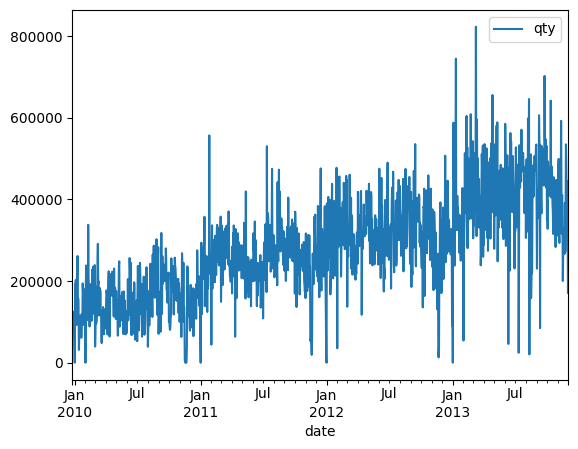

In [10]:
df.plot()

### Разложим ряд на тренд, сезонность и шум

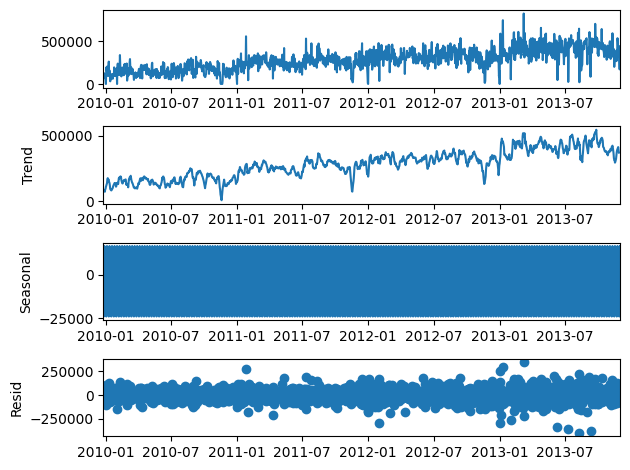

In [28]:
decomposition = seasonal_decompose(df)
decomposition.plot()
plt.show()

### Выделим последнее значение как тестовое

In [21]:
test_df = df.iloc[-1]
train_df = df.iloc[:-1]
test_df

qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64

### Построим прогноз на одно последнее значение с помощью экспоненциального сглаживания (`=0.7`) и сравним результат с фактическим значением, которое мы отложили вначале.

In [23]:
ses = SimpleExpSmoothing(train_df)
model = ses.fit(smoothing_level=0.7)
exp_pred = model.forecast(1)
exp_pred


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2013-12-02    225015.522647
Freq: D, dtype: float64

Проверим ряд на стационарность, определим порядок интегрирования.

In [25]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  -2.255302641033781
p-value:  0.186789031234171
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
есть единичные корни, ряд не стационарен


Ряд не стационарен, необходимо взять разности первого порядка

In [26]:
df_diff_1 = df.diff(periods=1).dropna()
stat_test(df_diff_1)

adf:  -13.821839865226535
p-value:  7.878856681053815e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
единичных корней нет, ряд стационарен


Получившийся ряд стационарен, порядок интегрирования = 1.

### Определим порядок модели AR по графику частичной автокорреляции.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


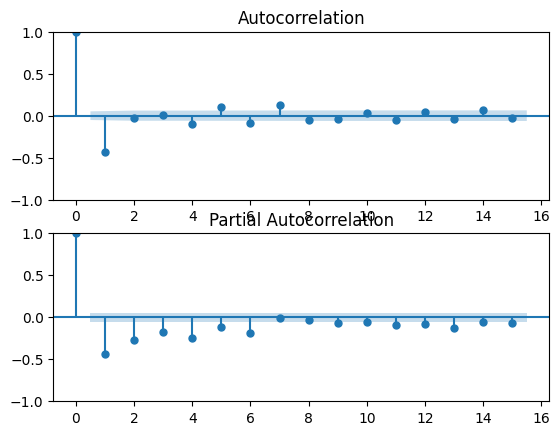

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1)
lags = 15
fig = sm.graphics.tsa.plot_acf(df_diff_1.values.squeeze(), lags=lags, ax=ax1)
fig = sm.graphics.tsa.plot_pacf(df_diff_1, lags=lags, ax=ax2)


По графику определяем порядок модели:

In [61]:
p = 6

### Постройте модель AR и предскажите последнее значение ряда.

Модель строится на исходном временном ряду.

In [62]:
ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(6)   Log Likelihood              -18221.056
Method:               Conditional MLE   S.D. of innovations          81248.064
Date:                Sun, 21 May 2023   AIC                          36458.111
Time:                        17:00:48   BIC                          36500.246
Sample:                    12-31-2009   HQIC                         36473.844
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.047e+04   6160.175      4.946      0.000    1.84e+04    4.25e+04
qty.L1         0.3074      0.026     11.654      0.000       0.256       0.359
qty.L2         0.1582      0.027      5.835      0.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [63]:
ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    318174.284553
Freq: D, dtype: float64

### Сравним полученные результаты

In [64]:
print(f'EXP_model result = {exp_pred}')
print(f'AR_model result = {ar_pred}')
print(f'REAL result = {test_df}')

EXP_model result = 2013-12-02    225015.522647
Freq: D, dtype: float64
AR_model result = 2013-12-02    318174.284553
Freq: D, dtype: float64
REAL result = qty    423846.0
Name: 2013-12-02 00:00:00, dtype: float64


In [65]:
mean_squared_error(test_df, ar_pred), mean_squared_error(test_df, exp_pred)

(11166511445.47285, 39533558724.37031)